In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import linearmodels
import matplotlib as plt
import xlrd
import scipy
import os
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from linearmodels.panel import PanelOLS


In [137]:
# read data file, convert to csv
df = pd.read_excel('fpds_rates.xlsx')
df.to_csv('fpds_rates.csv')
data = pd.read_csv('fpds_rates.csv')

In [138]:
data.columns

Index(['Unnamed: 0', 'AgencyWide', 'department_id', 'department_name',
       'contracting_agency_id', 'contracting_agency_name', 'FiscalYear',
       'TotalActions', 'TotalDollars', 'CompetedActions', 'CompetedDollars',
       'CompRate', 'NotCompetedActions', 'NotCompetedDollars', 'NotCompRate',
       'OneBidActions', 'OneBidDollars', 'OneBidRate', 'EffCompActions',
       'EffCompDollars', 'EffCompRate', 'SbActions', 'SbDollars', 'SbUtilRate',
       'SdbActions', 'SdbDollars', 'SdbRate', 'WosbActions', 'WosbDollars',
       'WosbRate', 'SdvosbcActions', 'SdvosbcDollars', 'SdvosbcRate',
       'HubZoneActions', 'HubZoneDollars', 'HubZoneRate', 'OtsbActions',
       'OtsbDollars', 'OtsbRate', 'EligibleActions', 'EligibleDollars',
       'SB+OTSB', 'OneBidRate+EffCompRate'],
      dtype='object')

In [242]:

len(df)

1171

# First Thoughts

Right off the bat the assumptions of independence and multicolinearity are violated as all variables included in the regression are functions of total dollars obligated.  If one moves a certain percentage then obviously another will decrease at a certain proportion.  Having said this the coefficients of the regressors will likely be negative, as an increase in one variable will decrease total dollars that feed into the othe proportions.  This causes problems interpreting the actual coefficients becasue the assumption of independence is violated; it is impossible to interperet the change of y given x holding all other things constant.    

Also a regressor is a proportion of the y variable.  So if y = a/b then the x value is 1-a/b, which violates all sorts of things.  

## Purpose / Path Forward

I'm going to run this regression through several "what-if" scenarios to try and recreate the panel regression written in the proprietary econometric software eviews.  I do not have any code or file from eviews, so the only thing that I have to work from is the regression output itself.  

This is also necessary as information of the actual method used is difficult to extricate from the originator.  



## Possible Sources of Error / Assumptions

As much as I dislike proprietary statistical software, their whole existance revolves around the production of esoteric statistical analyses.  This means that despite being an excellent language Python does lag behind in some areas, so manual processes will have to replace them which adds a factor of uncertainty.  An example is lagging data in a Pandas DataFrame.

I'm not certain how the data was cleaned and/or removed so I'm adding different methods to the "what-if" analysis.  

I'm not certain what transformations were done or what variables left out.  I know Panel Ordinary Least Squares is used, so is a Fixed Effects model.  N = 626, and a time lag of one is used on a certain independent variable.  


# Data Cleaning

In [205]:
# drop agency umbrella variable
#
# some records have not obligated dollars, so I'll drop those as it does not make sense to include agencies who did not participate in any contracting actions in a
# regression measuring the dollar impact of contracting actions. Also certain rates used in the regression use TotalDollars in the denominator
#
# some recrods don't have competed dollars, removed those as well for same reason above
#
# removed negatives

data1 = data[data['AgencyWide']!=1]
data1 = data1[data1['TotalDollars']>0]
data1= data1[data1['OneBidRate']>0]
data1 = data1[data1['SdbRate']>0]
data1 = data1[data1['NotCompRate']>0]
data1 = data1[data1['EffCompRate']>0]

len(data1)

761

# EDA

## Histograms to check for normality of ind. variables

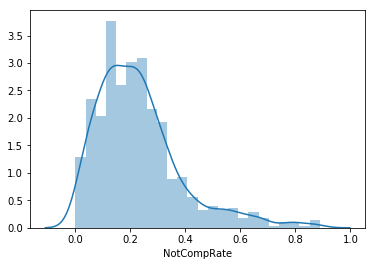

In [244]:
sns.distplot(data1['NotCompRate'])

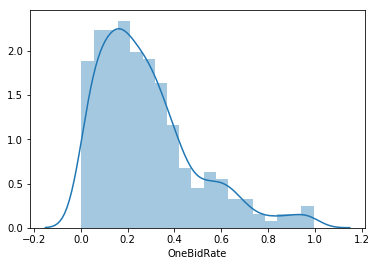

In [158]:
sns.distplot(data1['OneBidRate'])

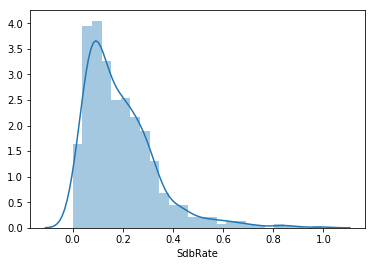

In [159]:
sns.distplot(data1['SdbRate'])

## check for linearity

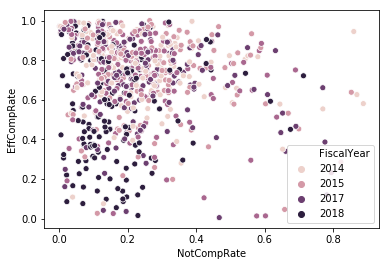

In [160]:
sns.scatterplot(x=data1['NotCompRate'],y=data1['EffCompRate'],hue = data1['FiscalYear'])

This plot demonstrates the relationship of the dependent/independent varaible mentioned above.

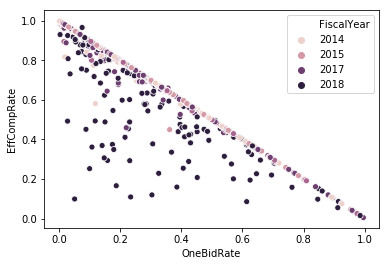

In [161]:
sns.scatterplot(x=data1['OneBidRate'],y=data1['EffCompRate'],hue = data1['FiscalYear'])

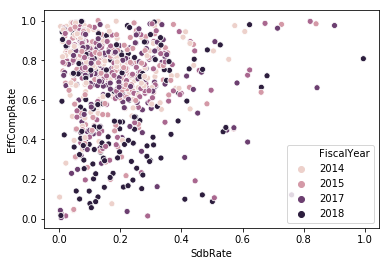

In [162]:
sns.scatterplot(x=data1['SdbRate'],y=data1['EffCompRate'],hue = data1['FiscalYear'])

## check for multicolinearity

# First pass at a model

only using cleaned data w/o transformations

In [206]:
year = pd.Categorical(data1.FiscalYear)
data1 = data1.set_index(['contracting_agency_name','FiscalYear'])
data1['FiscalYear'] = year

In [207]:
exog_vars = ['SdbRate','OneBidRate','NotCompRate']
exog = sm.add_constant(data1[exog_vars])
mod = PanelOLS(data1.EffCompRate, exog, entity_effects=True, time_effects=True)
fe_te_res = mod.fit()
print(fe_te_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            EffCompRate   R-squared:                        0.6423
Estimator:                   PanelOLS   R-squared (Between):              0.9296
No. Observations:                 761   R-squared (Within):               0.5668
Date:                Wed, Apr 17 2019   R-squared (Overall):              0.8041
Time:                        17:07:24   Log-likelihood                    970.54
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      357.36
Entities:                         157   P-value                           0.0000
Avg Obs:                       4.8471   Distribution:                   F(3,597)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             357.36
                            

next, use lag of one

In [209]:
data2 = data1[['SdbRate','OneBidRate','NotCompRate','EffCompRate']]

In [211]:
data2['SdbRate_shift'] = data2.groupby(level=0)['SdbRate'].shift(1)
data2['OneBidRate_shift'] = data2.groupby(level=0)['OneBidRate'].shift(1)
data2['NotCompRate_shift'] = data2.groupby(level=0)['NotCompRate'].shift(1)
data2['EffCompRate_shift'] = data2.groupby(level=0)['EffCompRate'].shift(1)

/Users/scottbchrist/.local/share/virtualenvs/contracting-hypotheses-cjDr5z3c/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/scottbchrist/.local/share/virtualenvs/contracting-hypotheses-cjDr5z3c/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/scottbchrist/.local/share/virtualenvs/contracting-hypotheses-cjDr5z3c/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopy

In [212]:
data2 = data2.iloc[data2.index.get_level_values('FiscalYear') >2014]

In [213]:
exog_vars = ['SdbRate_shift','OneBidRate_shift','NotCompRate_shift']
exog2 = sm.add_constant(data2[exog_vars])
mod2 = PanelOLS(data2.EffCompRate_shift, exog2, entity_effects=True, time_effects=True)
fe_te_res2 = mod2.fit()
print(fe_te_res2)

                          PanelOLS Estimation Summary                           
Dep. Variable:      EffCompRate_shift   R-squared:                        0.9406
Estimator:                   PanelOLS   R-squared (Between):              0.9858
No. Observations:                 600   R-squared (Within):               0.9402
Date:                Wed, Apr 17 2019   R-squared (Overall):              0.9807
Time:                        17:10:00   Log-likelihood                    1524.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2332.2
Entities:                         152   P-value                           0.0000
Avg Obs:                       3.9474   Distribution:                   F(3,442)
Min Obs:                       1.0000                                           
Max Obs:                       12.000   F-statistic (robust):             2332.2
                            

/Users/scottbchrist/.local/share/virtualenvs/contracting-hypotheses-cjDr5z3c/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottbchrist/.local/share/virtualenvs/contracting-hypotheses-cjDr5z3c/lib/python3.7/site-packages/linearmodels/utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [196]:
len(data2)

608

# Same analysis but with only filling na vaules with 0

In [197]:
data_null = data1[['SdbRate','OneBidRate','NotCompRate','EffCompRate']]

In [222]:
data3 = data[data['AgencyWide']==0]

In [224]:
data3.fillna(0)

,Unnamed: 0,AgencyWide,department_id,department_name,contracting_agency_id,contracting_agency_name,FiscalYear,TotalActions,TotalDollars,CompetedActions,...,HubZoneActions,HubZoneDollars,HubZoneRate,OtsbActions,OtsbDollars,OtsbRate,EligibleActions,EligibleDollars,SB+OTSB,OneBidRate+EffCompRate
4,4,0,300,LIBRARY OF CONGRESS,300,LIBRARY OF CONGRESS,2014,24,0.000000e+00,24,...,0.0,0.00,0.000000,21.0,0.000000e+00,0.000000,24.0,0.000000e+00,0,0
5,5,0,300,LIBRARY OF CONGRESS,300,LIBRARY OF CONGRESS,2015,10,0.000000e+00,10,...,0.0,0.00,0.000000,6.0,0.000000e+00,0.000000,10.0,0.000000e+00,0,0
6,6,0,300,LIBRARY OF CONGRESS,300,LIBRARY OF CONGRESS,2016,7,0.000000e+00,6,...,0.0,0.00,0.000000,4.0,0.000000e+00,0.000000,7.0,0.000000e+00,0,0
7,7,0,300,LIBRARY OF CONGRESS,300,LIBRARY OF CONGRESS,2017,18,0.000000e+00,18,...,1.0,0.00,0.000000,7.0,0.000000e+00,0.000000,18.0,0.000000e+00,0,0
13,13,0,500,GOVERNMENT ACCOUNTABILITY OFFICE,559,"GAO, EXCEPT COMPTROLLER GENERAL",2014,546,5.375475e+07,394,...,12.0,751805.51,0.014780,335.0,3.962074e+07,0.778946,539.0,5.086456e+07,0.999999,0.999999
14,14,0,500,GOVERNMENT ACCOUNTABILITY OFFICE,559,"GAO, EXCEPT COMPTROLLER GENERAL",2015,599,5.121096e+07,424,...,10.0,581315.26,0.012124,363.0,3.853803e+07,0.803795,595.0,4.794508e+07,0.999999,0.999999
15,15,0,500,GOVERNMENT ACCOUNTABILITY OFFICE,559,"GAO, EXCEPT COMPTROLLER GENERAL",2016,966,5.517796e+07,691,...,33.0,749622.51,0.014345,620.0,4.541218e+07,0.869042,968.0,5.225544e+07,0.999999,0.999999
16,16,0,500,GOVERNMENT ACCOUNTABILITY OFFICE,559,"GAO, EXCEPT COMPTROLLER GENERAL",2017,1033,5.300587e+07,683,...,49.0,815509.94,0.015382,638.0,4.160047e+07,0.784690,1038.0,5.301516e+07,0.999999,0.999851
17,17,0,500,GOVERNMENT ACCOUNTABILITY OFFICE,559,"GAO, EXCEPT COMPTROLLER GENERAL",2018,496,6.064336e+07,267,...,24.0,392112.86,0.006469,292.0,4.886379e+07,0.806235,493.0,6.060731e+07,0.999999,0.920155
23,23,0,1100,EXECUTIVE OFFICE OF THE PRESIDENT,1100,EXECUTIVE OFFICE OF THE PRESIDENT,2014,820,7.322452e+07,496,...,24.0,676044.30,0.009251,300.0,3.214825e+07,0.439942,835.0,7.307377e+07,0.999999,1.00002


In [225]:
year3 = pd.Categorical(data3.FiscalYear)
data3 = data3.set_index(['contracting_agency_name','FiscalYear'])
data3['FiscalYear'] = year3
exog_vars3 = ['SdbRate','OneBidRate','NotCompRate']
exog3 = sm.add_constant(data3[exog_vars3])
mod3 = PanelOLS(data3.EffCompRate, exog3, entity_effects=True, time_effects=True)
fe_te_res3 = mod3.fit()
print(fe_te_res3)

                          PanelOLS Estimation Summary                           
Dep. Variable:            EffCompRate   R-squared:                        0.6837
Estimator:                   PanelOLS   R-squared (Between):              0.9233
No. Observations:                 792   R-squared (Within):               0.6430
Date:                Thu, Apr 18 2019   R-squared (Overall):              0.8092
Time:                        10:12:42   Log-likelihood                    914.33
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      448.24
Entities:                         163   P-value                           0.0000
Avg Obs:                       4.8589   Distribution:                   F(3,622)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             448.24
                            

In [236]:
data4 = data3
data4['SdbRate_shift'] = data4.groupby(level=0)['SdbRate'].shift(1)
data4['OneBidRate_shift'] = data4.groupby(level=0)['OneBidRate'].shift(1)
data4['NotCompRate_shift'] = data4.groupby(level=0)['NotCompRate'].shift(1)
data4['EffCompRate_shift'] = data4.groupby(level=0)['EffCompRate'].shift(1)
data4 = data4.iloc[data4.index.get_level_values('FiscalYear') >2014]

In [237]:

exog_vars4 = ['SdbRate','OneBidRate','NotCompRate']
exog4 = sm.add_constant(data4[exog_vars4])
mod4 = PanelOLS(data4.EffCompRate, exog4, entity_effects=True, time_effects=True)
fe_te_res4= mod4.fit()
print(fe_te_res4)

                          PanelOLS Estimation Summary                           
Dep. Variable:            EffCompRate   R-squared:                        0.6420
Estimator:                   PanelOLS   R-squared (Between):              0.8371
No. Observations:                 633   R-squared (Within):               0.6120
Date:                Thu, Apr 18 2019   R-squared (Overall):              0.7537
Time:                        10:18:02   Log-likelihood                    713.40
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      278.54
Entities:                         161   P-value                           0.0000
Avg Obs:                       3.9317   Distribution:                   F(3,466)
Min Obs:                       1.0000                                           
Max Obs:                       13.000   F-statistic (robust):             278.54
                            

/Users/scottbchrist/.local/share/virtualenvs/contracting-hypotheses-cjDr5z3c/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottbchrist/.local/share/virtualenvs/contracting-hypotheses-cjDr5z3c/lib/python3.7/site-packages/linearmodels/utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


### setting a robust covariance to control for heteroskedasticity

In [245]:
exog_vars4 = ['SdbRate','OneBidRate','NotCompRate']
exog4 = sm.add_constant(data4[exog_vars4])
mod4 = PanelOLS(data4.EffCompRate, exog4, entity_effects=True, time_effects=True)
fe_te_res4= mod4.fit(cov_type='robust')
print(fe_te_res4)

                          PanelOLS Estimation Summary                           
Dep. Variable:            EffCompRate   R-squared:                        0.6420
Estimator:                   PanelOLS   R-squared (Between):              0.8371
No. Observations:                 633   R-squared (Within):               0.6120
Date:                Wed, Apr 24 2019   R-squared (Overall):              0.7537
Time:                        15:14:33   Log-likelihood                    713.40
Cov. Estimator:                Robust                                           
                                        F-statistic:                      278.54
Entities:                         161   P-value                           0.0000
Avg Obs:                       3.9317   Distribution:                   F(3,466)
Min Obs:                       1.0000                                           
Max Obs:                       13.000   F-statistic (robust):             65.938
                            